In [1]:
from qiskit import QuantumCircuit
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer import AerSimulator
from qiskit.result import sampled_expectation_value
from qiskit.quantum_info import SparsePauliOp

from qiskit.visualization import plot_histogram

from numpy import *

In [2]:
!pip install prototype-zne

In [3]:
from numpy.random import default_rng
from numpy import pi
from qiskit.circuit import Parameter, ParameterVector


def build_qaoa_circuit(
        num_qubits: int, 
        depth: int, 
        measurements: bool = True, 
        barriers: bool = False, 
) -> QuantumCircuit:
    """Build parameterized QAOA quantum circuit.
    
    Args:
        num_qubits: number of qubits.
        depth: two-qubit depth (needs to be even).
        measurements: if True adds measurements at the end.
        barriers: if True adds barriers between layers.
    Returns:
        A dense QAOA quantum circuit for a linear, non-cyclic, graph
        with cost parameter-vector γ, and mixer parameter-vector β.
    """
    if num_qubits <= 2:
        raise ValueError("Number of qubits must be greater than two.")
    if depth % 2 != 0:
        raise ValueError("Depth must be even.")
    
    gammas = ParameterVector('γ', depth // 2) 
    betas = ParameterVector('β', depth // 2)

    circuit = QuantumCircuit(num_qubits)
    circuit.h(range(num_qubits))
    for layer in range(depth // 2):
        if barriers:
            circuit.barrier()
        for qubit in range(0, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(1, num_qubits - 1, 2):
            circuit.rzz(gammas[layer], qubit, qubit + 1)
        for qubit in range(num_qubits):
            circuit.rx(betas[layer], qubit)
    
    if measurements:
        circuit.measure_all()
    return circuit


def produce_qaoa_parameters(num_layers, *, seed=None):
    """Produce random QAOA parameters.
    Args:
        num_layers: the number of QAOA layers.
        seed: a seed to generate the random angles.
    Returns:
        A tuple holding the beta and gamma angles.
    """
    rng = default_rng(seed=seed)
    betas = rng.uniform(-pi, pi, size=num_layers).tolist()
    gammas = rng.uniform(-pi, pi, size=num_layers).tolist()
    return betas, gammas


def build_compute_uncompute_qaoa_circuit(
        num_qubits: int, 
        depth: int, 
        *,
        measurements: bool = True, 
        barriers: bool = False, 
    ) -> QuantumCircuit:
    """Build a parametrized compute-uncompute QAOA quantum circuit."""
    if depth % 4 != 0:
       raise ValueError("Depth must be a multiple of four.")

    qaoa = build_qaoa_circuit(num_qubits, depth // 2, measurements=False, barriers=barriers)
    
    circuit = QuantumCircuit(num_qubits)
    circuit.compose(qaoa, inplace=True)
    circuit.barrier()
    circuit.compose(qaoa.inverse(), inplace=True)
    if measurements:
        circuit.measure_all(inplace=True)
    
    return circuit

In [4]:
num_qubits = 12
p = 1 # QAOA terminology
shots = 10000

observables = []

# Considering only wt-1 observables for brevity
for i in range(num_qubits):
    obs = 'I'*i + 'Z'*1 + 'I'*(num_qubits-i-1)
    observables.append(obs)

In [5]:
observables

['ZIIIIIIIIIII',
 'IZIIIIIIIIII',
 'IIZIIIIIIIII',
 'IIIZIIIIIIII',
 'IIIIZIIIIIII',
 'IIIIIZIIIIII',
 'IIIIIIZIIIII',
 'IIIIIIIZIIII',
 'IIIIIIIIZIII',
 'IIIIIIIIIZII',
 'IIIIIIIIIIZI',
 'IIIIIIIIIIIZ']

In [7]:
qc = build_compute_uncompute_qaoa_circuit(num_qubits,4*p)

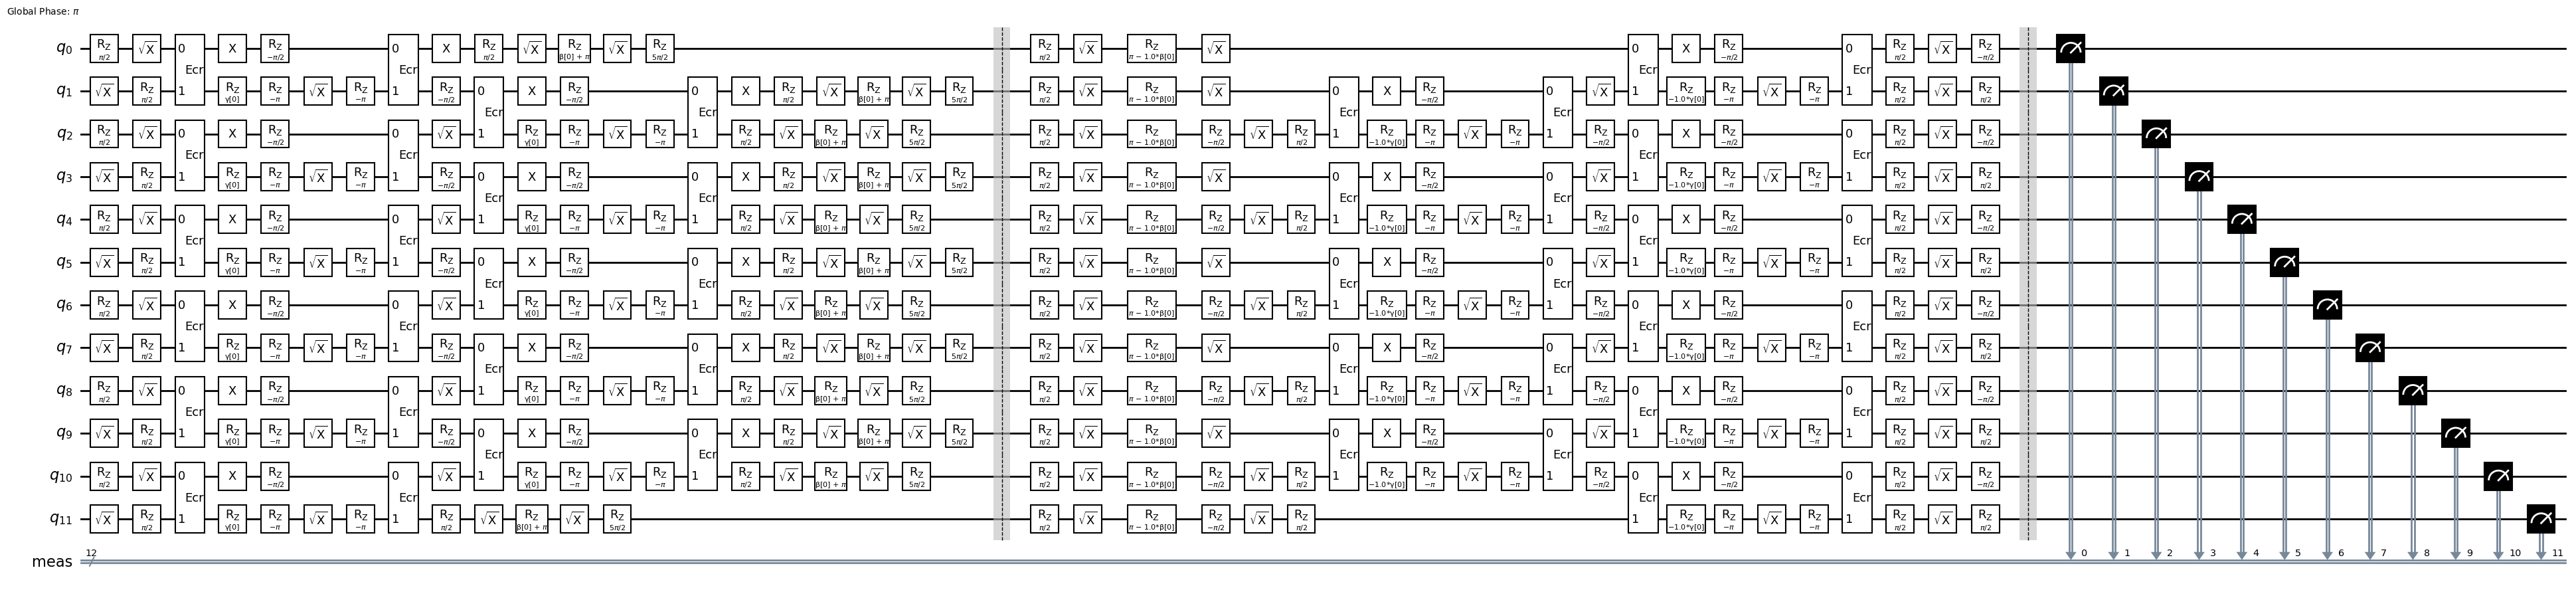

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(2, basis_gates=['x','sx','rz','ecr','id'])

qc = pm.run(qc)
qc.draw('mpl',style='bw',fold=-1)

In [10]:
betas, gammas = produce_qaoa_parameters(p, seed=0)
params = [gammas[0], betas[0]]
params

[-1.4464727375963786, 0.8605556614246863]

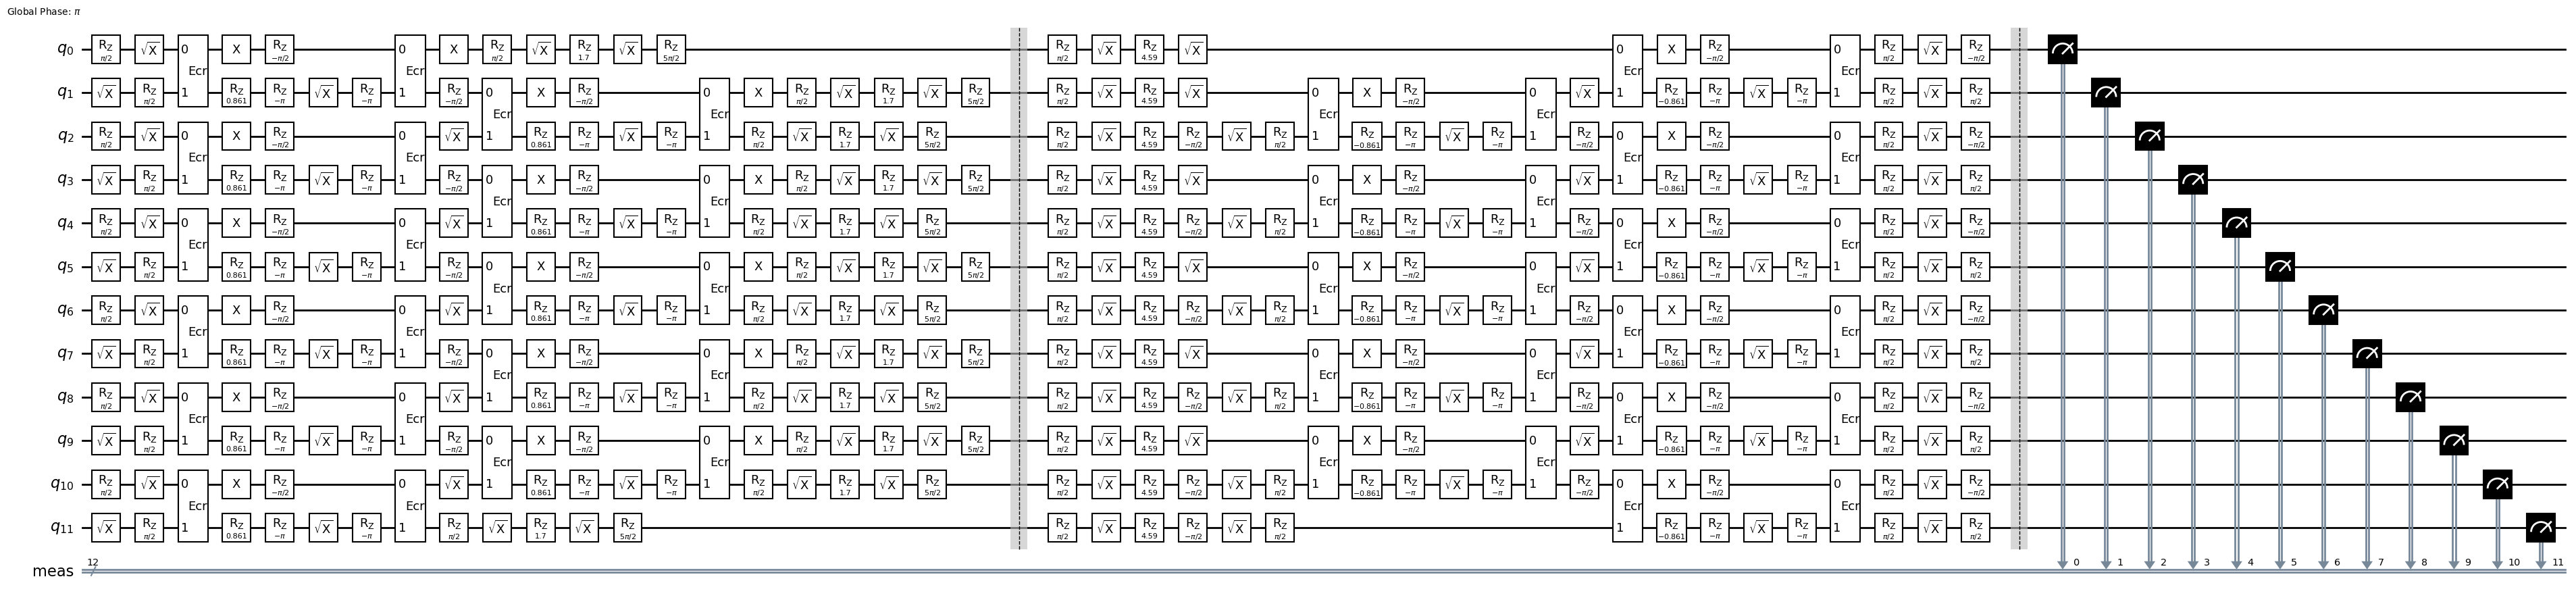

In [11]:
qc = qc.assign_parameters(params)
qc.draw('mpl',style='bw',fold=-1)

### ZNE for a depolarization noise environment

In [12]:
def create_depolarization_error(p_depol: float) -> NoiseModel:
    noise_model = NoiseModel()
    error = depolarizing_error(p_depol,2)
    noise_model.add_all_qubit_quantum_error(error,['cx'])
    return noise_model

In [13]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import CouplingMap

backend = GenericBackendV2(
    num_qubits=num_qubits,
    basis_gates=['x','sx','rz','ecr','id'],
    coupling_map=CouplingMap.from_line(num_qubits)
)

noise_model = create_depolarization_error(0.01)
backend.set_options(**{'noise_model':noise_model})

#### First we check the noisy outcome without any mitigation

In [14]:
noisy_count = backend.run(qc, shots=shots).result().get_counts()

In [15]:
noisy_count

{'110001000000': 1,
 '000011001000': 1,
 '001000010000': 1,
 '001000001010': 1,
 '000011000001': 1,
 '000011000010': 1,
 '000001110001': 1,
 '011000110000': 1,
 '100000011000': 1,
 '000000100110': 1,
 '001000110000': 1,
 '000001001100': 3,
 '100001110000': 1,
 '001000000001': 1,
 '001111000011': 1,
 '111000011000': 1,
 '110000010000': 1,
 '000011100100': 1,
 '010000001000': 1,
 '000110100000': 1,
 '000000111010': 1,
 '010001010000': 1,
 '110000100000': 1,
 '100010000000': 1,
 '000000010001': 1,
 '001001000101': 1,
 '001100110000': 2,
 '010000010000': 2,
 '000000100010': 1,
 '010000100000': 2,
 '100010000110': 1,
 '010000000001': 1,
 '001101110000': 1,
 '110000000010': 1,
 '000011110000': 2,
 '000000010010': 1,
 '000000111000': 6,
 '010100000000': 4,
 '000000111100': 5,
 '001111000000': 8,
 '110000000100': 2,
 '001000001000': 4,
 '000011010000': 5,
 '110100010000': 1,
 '000000001101': 5,
 '000000000010': 69,
 '000000011100': 6,
 '100000000011': 1,
 '000000000100': 74,
 '000001000100': 1

#### Calculate the expectation values of the observables

In [16]:
expvals = []

for obs in observables:
    expval = sampled_expectation_value(noisy_count, obs)
    expvals.append(expval)

avg_expval = mean(expvals)

In [17]:
avg_expval

0.9448166666666666

### Zero Noise Extrapolation

#### Amplify the circuit

In [18]:
from zne.noise_amplification import TwoQubitAmplifier

In [19]:
NOISE_FACTORS = [1,3,5]
NOISE_AMPLIFIER = TwoQubitAmplifier(sub_folding_option='random', random_seed=0)

In [20]:
def amplify_noise(qc: QuantumCircuit, nf, noise_amplifier) -> QuantumCircuit:
    if nf == 1:
        return qc
    else:
        return noise_amplifier.amplify_circuit_noise(qc, nf)

In [21]:
def create_amplified_circuits(qc: QuantumCircuit, NOISE_FACTORS: list, NOISE_AMPLIFIER) -> dict:
    zne_circuits = {
        nf: amplify_noise(qc, nf, NOISE_AMPLIFIER)
        for nf in NOISE_FACTORS
    }
    return zne_circuits

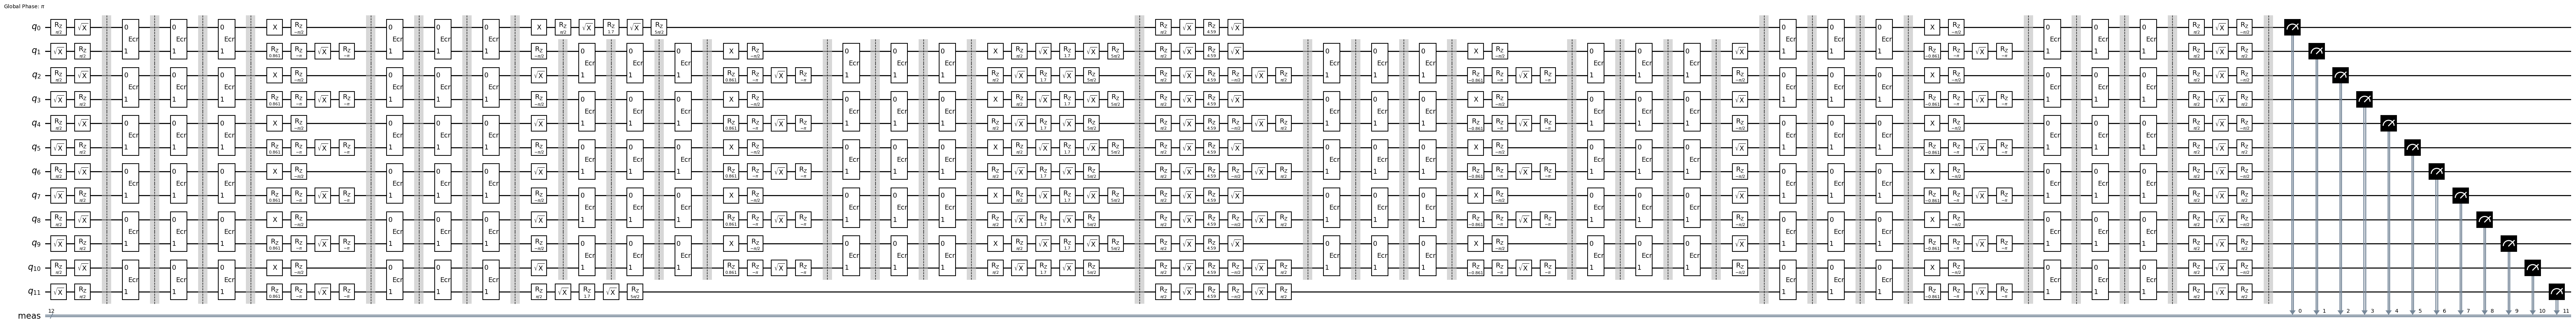

In [22]:
zne_circuits = create_amplified_circuits(qc, NOISE_FACTORS, NOISE_AMPLIFIER)
zne_circuits[3].draw('mpl', style='bw', fold=-1)

In [23]:
def get_amplified_counts(zne_circuits: dict, backend) -> dict:
    zne_counts = {
        nf: backend.run(zne_circuits[nf],shots=shots).result().get_counts()
        for nf in list(zne_circuits.keys())
    }
    return zne_counts

In [24]:
zne_counts = get_amplified_counts(zne_circuits, backend)

In [25]:
def get_amplified_expvals(zne_counts: dict) -> dict:
    zne_expvals = {}
    
    for nf in list(zne_counts.keys()):
        expvals_amplified = []
        for obs in observables:
            expval_ = sampled_expectation_value(zne_counts[nf], obs)
            expvals_amplified.append(expval_)
        zne_expvals[nf] = mean(expvals_amplified)

    return zne_expvals

In [26]:
zne_expvals = get_amplified_expvals(zne_counts)
zne_expvals

{1: 0.9420166666666666, 3: 0.8552666666666666, 5: 0.77955}

#### Extrapolate to zero noise

In [27]:
from zne.extrapolation import *

In [28]:
extrapolator = LinearExtrapolator()

In [29]:
extrapolated_mean = extrapolator.extrapolate_zero(list(zne_expvals.keys()), list(zne_expvals.values()))

In [30]:
extrapolated_mean.value

0.9807944443179496

### Deeper circuits

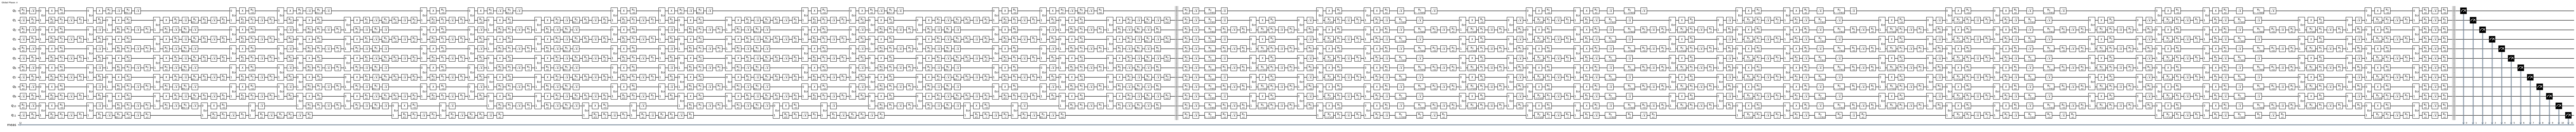

In [31]:
p = 6
qc_deep = build_compute_uncompute_qaoa_circuit(num_qubits,4*p)
qc_deep = pm.run(qc_deep)
qc_deep.draw('mpl',style='bw',fold=-1)

In [32]:
betas, gammas = produce_qaoa_parameters(p, seed=0)
params = [gammas[0], betas[0], gammas[1], betas[1], gammas[2], betas[2], gammas[3], betas[3], gammas[4], betas[4], gammas[5], betas[5]]
params

[0.6700123395200417,
 0.8605556614246863,
 1.441969420022903,
 -1.4464727375963786,
 0.27410390540137985,
 -2.8841484100105235,
 2.7336406607023154,
 -3.03774645687452,
 1.9845664104768632,
 1.9683349641197863,
 -3.1243861495570098,
 2.5934197786078093]

In [33]:
qc_deep = qc_deep.assign_parameters(params)

#### Perform amplification and extrapolation as before

In [34]:
zne_circuits_deep = create_amplified_circuits(qc_deep, NOISE_FACTORS, NOISE_AMPLIFIER)

In [36]:
zne_counts_deep = get_amplified_counts(zne_circuits_deep, backend)

In [37]:
zne_expvals_deep = get_amplified_expvals(zne_counts_deep)
zne_expvals_deep

{1: 0.6972999999999999, 3: 0.3773666666666667, 5: 0.2128}

In [38]:
extrapolator = LinearExtrapolator()
extrapolated_mean_deep = extrapolator.extrapolate_zero(list(zne_expvals_deep.keys()), list(zne_expvals_deep.values()))

In [39]:
extrapolated_mean_deep.value

0.7925305555572841

#### At this scale, a linear approximation is not sufficient. So we shift to exponential extrapolator

In [40]:
extrapolator = MonoExponentialExtrapolator()
extrapolated_mean_deep = extrapolator.extrapolate_zero(list(zne_expvals_deep.keys()), list(zne_expvals_deep.values()))
extrapolated_mean_deep.value

0.9570748096548135

#### Also think of partial folding

In [41]:
NOISE_FACTORS = [1,1.2,1.4]
zne_circuits_deep = create_amplified_circuits(qc_deep, NOISE_FACTORS, NOISE_AMPLIFIER)

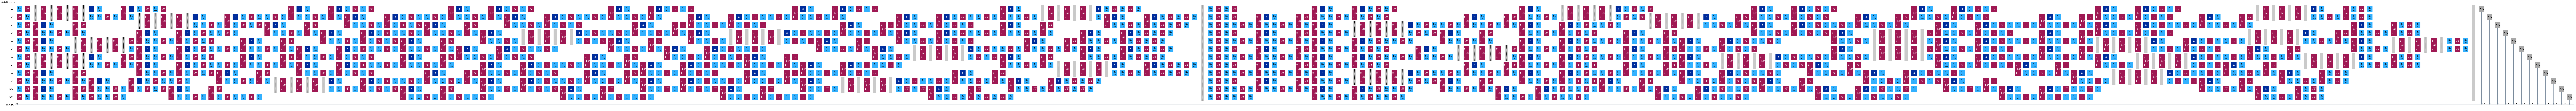

In [42]:
zne_circuits_deep[1.2].draw(fold=-1)

In [43]:
zne_counts_deep = get_amplified_counts(zne_circuits_deep, backend)
zne_expvals_deep = get_amplified_expvals(zne_counts_deep)
zne_expvals_deep

{1: 0.6996166666666666, 1.2: 0.6587833333333333, 1.4: 0.6118}

The expectation values with partial folding are much better than the previous scenario

In [59]:
extrapolator = LinearExtrapolator()
extrapolated_mean_deep = extrapolator.extrapolate_zero(list(zne_expvals_deep.keys()), list(zne_expvals_deep.values()))

In [60]:
extrapolated_mean_deep.value

0.8855083328704316

In [65]:
extrapolator = PolynomialExtrapolator(degree=2)
extrapolated_mean_deep = extrapolator.extrapolate_zero(list(zne_expvals_deep.keys()), list(zne_expvals_deep.values()))
extrapolated_mean_deep.value

1.029050000000002

In [61]:
extrapolator = MonoExponentialExtrapolator()
extrapolated_mean_deep = extrapolator.extrapolate_zero(list(zne_expvals_deep.keys()), list(zne_expvals_deep.values()))
extrapolated_mean_deep.value

1.0721336294360666